

# Projet: Analyser un ensemble de données sur des rendez-vous médicaux pour prédire au mieux les absences potentielles 

## Sommaire
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

## <a id='intro'></a>
## Introduction

### Le dataset :

Il s'agit de données collectées durant l'année 2016 au Brésil sur environs 100 mille rendez-vous médicaux, avec des informations sur les patients (notamment leur age, sexe, maladies chroniques, et si ou non ils étaient présents pour leur rendez-vous). Le but de cette analyse est d'abord de comprendre s'il y a une quelconque corrélation entre les caractéristiques enregistrées pour savoir quand un rendez-vous a une forte probabilité d'avoir lieu --pour mieux prédire les absences.

### Les caractéristiques :

- PatientId : identifiant du patient
- AppointmentID : identifiant du rendez-vous
- Gender : sexe du patient
- ScheduledDay : la date et heure auquels le patient a pris le rendez-vous
- AppointmentDay : la date du rendez-vous médical
- Age 
- Neighbourhood : région de l'hopital
- Scholarship : si oui (1) ou non (0) le patient fait partie du programme Bolsa Familia de sécurité sociale
- Hipertension : si le patient est hypertendu (1=hypertendu, 0=non)
- Diabetes : si le patient est diabétique (1=diabetique, 0=non)
- Alcoholism : si le patient est alcoolique (1=alcoolique, 0=non)
- Handcap : le nombre d'handicaps dont souffre le patient
- SMS_received : si le patient a reçu des messages de rappels du rendez-vous (0=aucun rappel, 1=au moins 1 rappel par sms)
- No-show : si le patient a été présent pour le rendez-vous (Yes=absent, No=présent)

### Questions à explorer :


- Est-ce que les patients absents pour leur rendez-vous ont reçu un rappel ?
- Est-ce que la durée entre la prise de rendez-vous et le rendez-vous favorise l'absence quand elle est longue ?
- Est-ce que certaines maladies caractéristiques sont plus communes chez les patients absents ?
- Est-ce que il y a une tranche d'age qui s'est absentée le plus à ses rendez-vous médical ?
- Est-ce que les absences sont plus fréquentes chez un sexe particulier ?
- Est-ce que les bénéficiaires du programme Bolsa Familia s'absentent plus ou moins que les non-bénéficiaires ?

In [82]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')


<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [83]:
# charger les données et en afficher quelques lignes
df=pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [84]:
df.shape

(110527, 14)

* Les noms des colonnes ne se prêtent pas facilement ni à la mémoire ni à l'usage.

* Je m'assure que les valeurs des colonnes Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received et No-show sont correctes :

In [85]:
df['Scholarship'].unique(), df['Hipertension'].unique(), df['Diabetes'].unique(), df['Alcoholism'].unique(), df['Handcap'].unique(), df['SMS_received'].unique(), df['No-show'].unique()

(array([0, 1]),
 array([1, 0]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1, 2, 3, 4]),
 array([0, 1]),
 array(['No', 'Yes'], dtype=object))

### Je vérifie les types de données des colonnes

In [86]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

* Je constate aussi que des les colonnes des dates/heures ne sont pas en mode datetime. Je dois y remédier tout de suite puisque j'envisage d'évaluer s'ils contiennent des données aberrantes.

In [87]:
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])
df.dtypes

PatientId                     float64
AppointmentID                   int64
Gender                         object
ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
Age                             int64
Neighbourhood                  object
Scholarship                     int64
Hipertension                    int64
Diabetes                        int64
Alcoholism                      int64
Handcap                         int64
SMS_received                    int64
No-show                        object
dtype: object

### Y a-t-il des données manquantes ?

In [88]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

### Y a-t-il des lignes dupliquées ?

In [89]:
df.duplicated().sum()

0

### Y a-t-il des données aberrantes ?

In [90]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


* Il est clair que la colonne Age contient des données insensées (des valeurs moins de 0 et d'autres plus de 100)
* Pour gérer ce probleme, je voudrais savoir combien y a-t-il de ces cas aberrants pour pouvoir décider quoi faire avec.

In [91]:
df.query('Age <0 or Age >=95').shape

(71, 14)

* Je suis maintenant curieux de voir s'il y a des ages de 0 et de combien

In [92]:
df.query('Age==0').shape

(3539, 14)

* Le nombre d'individus déclarés agés de <0 ou >=95 ans est insignifiants par rapport au volume de données, je peux donc me permettre de les supprimer sans que cela n'affecte la valeur de mon échantillon.
* Cependant, pour les âges de 0 ans il est à noter que le type de cette colonne est entier. Il est raisonnable de supposer alors qu'il s'agit de bébés avec leurs âges arrondis à l'unité. Je décide de garder ces données.

* Y a-t-il des rendez-vous (du même individu) qui ont été enregistré plus qu'une fois ?

In [93]:
df.duplicated(subset=['PatientId','Gender','Age','ScheduledDay','AppointmentDay']).sum()

1334

* Y a-t-il des prises de rendez-vous qui ont eu lieu après le rendez-vous médical ?

In [94]:
(df['AppointmentDay'].dt.date < df['ScheduledDay'].dt.date).sum()

5

### Data Cleaning

Aprés exploration des données, je constate le suivant :
   - Les noms des colonnes ne se prêtent pas facilement ni à la mémoire ni à l'usage.
   - Les colonnes Scholarship, Hipertension, Diabetes, Alcoholism, Handcap et enfin SMS_received ont des valeurs binaires pas immediatement interpretables.
   - La colonne PatientId est de type float alors que celle de AppointmentID est de type entier.
   - Il n'y a pas de données manquantes ni des lignes entièrement dupliquées mais il y a quelques redondances au niveau des rendez-vous pris (rendez-vous enregistré plus qu'une fois).
   - Il y a des âges qui sont moins de 0 ou plus de 95 ans.
   - Il y a des prises de rendez-vous qui sont datées aprés le rendez-vous médical.

Pour y remédier, je procederai à faire le suivant :
   - Convertir tous les noms des colonnes en de noms miniscules, plus mémorables selon :
       * PatientId = id_patient
       * AppointmentID = id_rdv
       * Gender = sexe
       * ScheduledDay = prise_de_rdv
       * AppointmentDay = rdv
       * Scholarship = bolsa_familia
       * Hipertension = hypertendu
       * Diabetes = diabetique
       * Alcoholism = alcoolique
       * Handcap = handicaps_nbr
       * SMS_received = rappel_sms
       * No-show = absent
   - Convertir les valeurs binaires des colonnes (Scholarship, Hipertension, Diabetes, Alcoholism et enfin SMS_received) ainsi que la colonne no-show en de simples 'oui' et 'non'. Convertir le type de données de ces colonnes pour correspondre aux nouvelles valeurs.
   - Convertir la colonne PatientId en type entier.
   - Supprimer les redondances (rendez-vous enregistrés plus qu'une fois).
   - Supprimer les données aberrantes :
       * les âges moins de 0 ans et plus ou égal à 95 ans.
       * les prises de rendez-vous qui datent d'après le rendez-vous en soi.
   - Supprimer la colonne AppointmentID (id_rdv) qui sera superflu une fois les rendez-vous redondants sont supprimés.

### Convertir tous les noms des colonnes :

In [95]:
df.rename(columns={'PatientId':'id_patient',
                   'AppointmentID':'id_rdv',
                   'Gender':'sexe',
                   'ScheduledDay':'prise_de_rdv',
                   'AppointmentDay':'rdv',
                   'Age':'age',
                   'Neighbourhood':'region_hopital',
                   'Scholarship':'bolsa_familia',
                   'Hipertension':'hypertendu',
                   'Diabetes':'diabetique',
                   'Alcoholism':'alcoolique',
                   'Handcap':'handicaps_nbr',
                   'SMS_received':'rappel_sms',
                   'No-show':'absent'}, inplace=True)
# verifier le résulat:
df.head(1)

,id_patient,id_rdv,sexe,prise_de_rdv,rdv,age,region_hopital,bolsa_familia,hypertendu,diabetique,alcoolique,handicaps_nbr,rappel_sms,absent
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No


### Remplacer les valeurs des colonnes:

In [96]:
binary_columns=['bolsa_familia','hypertendu','diabetique','alcoolique','rappel_sms']
df[binary_columns] = df[binary_columns].replace([0,1],['non','oui'])
df['absent'] = df['absent'].replace(['Yes','No'],['oui','non'])
df['bolsa_familia'].unique(), df['hypertendu'].unique(), df['diabetique'].unique(), df['alcoolique'].unique(), df['rappel_sms'].unique(), df['absent'].unique()

(array(['non', 'oui'], dtype=object),
 array(['oui', 'non'], dtype=object),
 array(['non', 'oui'], dtype=object),
 array(['non', 'oui'], dtype=object),
 array(['non', 'oui'], dtype=object),
 array(['non', 'oui'], dtype=object))

### Convertir la colonne id_patient en type entier: 

In [97]:
df=df.astype({'id_patient': 'int'})
df.dtypes

id_patient                      int64
id_rdv                          int64
sexe                           object
prise_de_rdv      datetime64[ns, UTC]
rdv               datetime64[ns, UTC]
age                             int64
region_hopital                 object
bolsa_familia                  object
hypertendu                     object
diabetique                     object
alcoolique                     object
handicaps_nbr                   int64
rappel_sms                     object
absent                         object
dtype: object

### Supprimer les redondances (rendez-vous enregistrés plus qu'une fois) :

In [98]:
df=df.drop_duplicates(subset=['id_patient','sexe','prise_de_rdv','rdv'],ignore_index=True)

# tester les résultats
df.duplicated(subset=['id_patient','sexe','prise_de_rdv','rdv']).sum()

0

 * Maintenant, je peux supprimer la colonne id_rdv puisqu'elle devient superflu.

In [99]:
df.drop('id_rdv',axis=1,inplace=True)
df.shape

(109193, 13)

### Supprimer les données aberrantes :

In [100]:
#les âges moins de 0 ans et plus ou égal à 95 ans.
df=df.drop(df.query('age < 0 or age >=95').index)

#les prises de rendez-vous qui datent d'après le rendez-vous en soi.
df=df.drop(df.query('prise_de_rdv.dt.date > rdv.dt.date').index)

In [101]:
# verifications :
print("nombre d'individus agés de <0 ou >=95 :",len(df.query('age < 0 or age >=95').index))
print("nombre de prises datés d'après le rdv :",len(df.query('prise_de_rdv.dt.date > rdv.dt.date').index))
df.shape

nombre d'individus agés de <0 ou >=95 : 0
nombre de prises datés d'après le rdv : 0


(109119, 13)

### Enregistrer les données nettoyées :

In [102]:
df.to_csv('clean_data.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis

### Quelques modifications nécessaires :

Avant d'aborder les questions, j'estime qu'il est nécessaire d'avoir trois nouvelles colonnes pour une analyse plus pertinente :
   1. une colonne qui contient le nombre de jours qui sépare la prise de rendez-vous et le rendez-vous, que je nommerai 'jours_au_rdv' (de type entier).
   2. une autre qui catégorise les âges en quatres tranches : mineurs (0-18), jeune (19-30), mur (31-45), vieux (46-94), que je nommerai 'tranche_age' (de type chaine de caractères).
   3. une dernière nommée 'handicape' qui distingue entre les gens handicappés (quelque soit le nombre de leurs handicaps) et les gens sans handicap, ayant pour valeur 'oui' et 'non' respectivement (de type chaine de caractère).

### Création de la colonne contenant les différences en jours entre la date de prise de rendez-vous et le rendez-vous

In [103]:
df['jours_au_rdv']= df['rdv'].dt.date - df['prise_de_rdv'].dt.date

In [104]:
df['jours_au_rdv'].sample(10)

15475     7 days
79682     8 days
20913     0 days
47351    21 days
46373    14 days
37914     0 days
63882     1 days
5715      0 days
36048     0 days
100039   21 days
Name: jours_au_rdv, dtype: timedelta64[ns]

    - il faut en extraire uniquement le nombre de jours. Je procède donc d'abord par convertir la colonne en chaine de caractère pour pouvoir utiliser la methode str et sa fonction extract.

In [105]:
df= df.astype({'jours_au_rdv':'str'})
df.dtypes

id_patient                      int64
sexe                           object
prise_de_rdv      datetime64[ns, UTC]
rdv               datetime64[ns, UTC]
age                             int64
region_hopital                 object
bolsa_familia                  object
hypertendu                     object
diabetique                     object
alcoolique                     object
handicaps_nbr                   int64
rappel_sms                     object
absent                         object
jours_au_rdv                   object
dtype: object

In [106]:
df['jours_au_rdv'] = df['jours_au_rdv'].str.extract('(\d+)').astype(int)
df['jours_au_rdv'].unique()

array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        49,  73,  64,  20,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  54,
        77,  69,  83,  76,  89,  81, 103,  79,  68,  75,  85, 112,  80,
        86,  98,  94, 142, 155, 162, 169, 104, 133, 125,  96,  88,  90,
       151, 126, 127, 111, 119,  74,  71,  82, 108, 110, 102, 122, 101,
       105,  92,  97,  93, 107,  95, 139, 132, 179, 117, 146, 123])

    * je m'assure que la nouvelle colonne ne contient pas de valeurs manquantes

In [107]:
df['jours_au_rdv'].isnull().sum()

0

    * ni de valeurs aberrantes

In [108]:
df['jours_au_rdv'].describe()

count    109119.000000
mean         10.066194
std          15.196887
min           0.000000
25%           0.000000
50%           4.000000
75%          14.000000
max         179.000000
Name: jours_au_rdv, dtype: float64

    * je veux m'assurer aussi qu'il n'y a pas des outliers

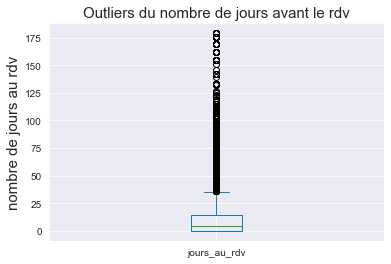

In [109]:
df['jours_au_rdv'].plot(kind='box')

plt.title('Outliers du nombre de jours avant le rdv',fontsize=15)
#plt.xlabel('Le libellé de l'axe des abscices')
plt.ylabel('nombre de jours au rdv',fontsize=15);

    * Il y a beaucoup d'outliers à partir d'environs 30 jours. Mais après consultation des médecins de mon entourage, je constate qu'il est possible chez certains médecins de prendre des rendez-vous de 6 mois d'avance (ce qui représente la plus grande durée de la colonne en question). Je décide donc de les garder pour le moment.

### Création d'une colonne contenant les tranches d'âges des patients (mineur, jeune, mur, vieux)

In [110]:
age_bins = [0 ,18 ,30 ,45 ,95]
bin_names =['mineur','jeune','mur','vieux']
df['tranche_age']=pd.cut(df['age'], age_bins, labels=bin_names,include_lowest=True)

    - je verifie encore qu'elle ne contient pas de valeurs manquantes

In [111]:
df['tranche_age'].isnull().sum()

0

### Création d'une colonne pour distinguer les handicapés des non-handicapés

In [112]:
df['handicaps_nbr'].describe()

count    109119.000000
mean          0.022058
std           0.160643
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: handicaps_nbr, dtype: float64

In [113]:
df['handicape']=df['handicaps_nbr'].apply(lambda x: 'non' if x==0 else 'oui')
df['handicape'].unique()

array(['non', 'oui'], dtype=object)

In [114]:
df['handicape'].isnull().sum()

0

    - je vérifie qu'il n'y a pas de valeurs contradictoires

In [115]:
df.query('handicape=="non" and handicaps_nbr>0').count().sum()

0

In [116]:
df.query('handicape=="oui" and handicaps_nbr == 0').count().sum()

0

    - je ne prévois pas de faire une analyse selon le nombre d'handicaps. Je supprime la colonne correspondante.

In [117]:
df.drop(['handicaps_nbr','prise_de_rdv','rdv'],axis=1,inplace=True)
df.shape

(109119, 13)

### Enregistrer les données après les dernières modifications

In [118]:
df.to_csv('modified_data.csv',index=False)

In [119]:
df.sample(5)

,id_patient,sexe,age,region_hopital,bolsa_familia,hypertendu,diabetique,alcoolique,rappel_sms,absent,jours_au_rdv,tranche_age,handicape
61551,325261823863,F,35,JABOUR,oui,non,non,non,oui,oui,35,mur,non
58167,74843914937688,F,27,SANTA TEREZA,non,non,non,non,non,oui,6,jeune,non
73590,625848675815,F,50,JARDIM CAMBURI,non,non,non,non,oui,non,11,vieux,non
41168,86353582821926,F,4,SÃO PEDRO,non,non,non,non,non,oui,7,mineur,non
40398,989417272579523,M,93,MARIA ORTIZ,non,non,non,non,non,non,34,vieux,non


### Est-ce que les patients absents pour leur rendez-vous ont reçu un rappel ?

    - pour aborder cette question, je dois faire un comptage des patients qui ont reçu un sms de rappel, parmi les absents et les présentes à leurs rendez-vous séparément.

In [120]:
totals = df.groupby('absent').count()['id_patient']
totals

absent
non    87275
oui    21844
Name: id_patient, dtype: int64

    - le nombre de patients absents et présents est différent, il serait donc plus rigoureux d'utiliser des proportions de chaque catégorie.

    - Rétrospectivement, je constate le besoin de calculer à plusieurs reprises des proportions, avec différents dataframes et totale par moment, je définis alors une fonction pour cela :

In [121]:
def proportion_calc(column_list, dataframe=df, total_counts=totals):  
    
    counts = dataframe.groupby(column_list).count()['id_patient']    

    absent_proportion = counts['oui']/total_counts['oui']
    present_proportion = counts['non']/total_counts['non']
    
    return counts, absent_proportion, present_proportion

In [122]:
sms_counts, absent_sms_proportion, present_sms_proportion = proportion_calc(['absent','rappel_sms'])

In [123]:
# je verifie la position des indices pour assigner correctement les labels de l'axe des x
absent_sms_proportion.index , present_sms_proportion.index

(Index(['non', 'oui'], dtype='object', name='rappel_sms'),
 Index(['non', 'oui'], dtype='object', name='rappel_sms'))

    - je dresse un graphe qui représente la proportion des patients qui ont reçu un sms de rappel contre celle des patients présents, et je compare avec le cas de ceux qui n'ont pas reçu d'sms.
    - avant cela, je définis une fonction qui permettra de dresser les mêmes types de graphes en cas de besoin.

In [124]:
def plot_bar(proportion1, proportion2, tick_labels, title, x_label, y_label):
    ind = np.arange(len(proportion1))
    width = 0.3
    absent_bar = plt.bar(ind, proportion1, width, color='r', alpha=.6, label='Absents au rdv')
    present_bar = plt.bar(ind+width, proportion2, width, color='g', alpha=.6, label='Présents au rdv')

    locations=ind+width/2
    labels = tick_labels
    plt.xticks(locations, labels)

    plt.title(title, fontsize=15)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.legend();

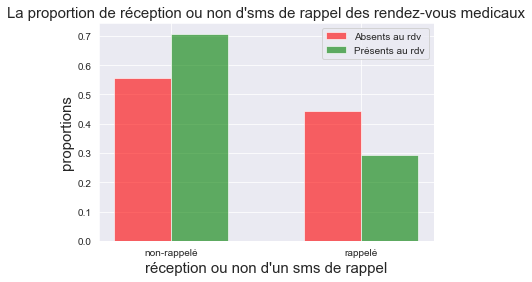

In [125]:
plot_bar(absent_sms_proportion, #proportion1
         present_sms_proportion, #proportion2
         ['non-rappelé', 'rappelé'], #tick_labels
         "La proportion de réception ou non d'sms de rappel des rendez-vous medicaux", #title
         "réception ou non d'un sms de rappel", #x_label
         "proportions") #y_label

    - On observe que les patients qui n'ont pas reçu de rappel sont plus nombreux.Parmi eux, il y a plus de patients qui se sont présentés aux rendez-vous.
    Parmi les patients qui ont reçu un rappel, on observe que c'est l'inverse : il y a plus d'absences dans cette catégorie.

### Est-ce que il y a une tranche d'age qui s'est absentée le plus à ses rendez-vous médical ?

    - je calcule les proportions nécessaires de chaque catégorie.

In [126]:
age_counts, absent_age_proportion, present_age_proportion = proportion_calc(['absent','tranche_age'])

    - je visualise la proportion des absents et des présents pour chaque tranche d'âge.

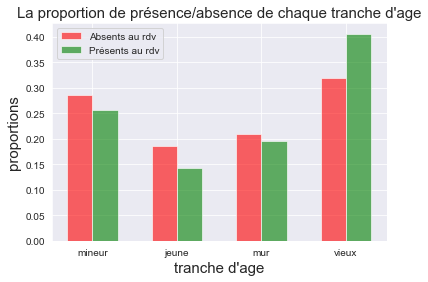

In [127]:
plot_bar(absent_age_proportion, #proportion1
         present_age_proportion, #proportion2
         ['mineur','jeune','mur','vieux'], #tick_labels
         "La proportion de présence/absence de chaque tranche d'age", #title
         "tranche d'age", #x_label
         "proportions") #y_label

    - On observe que la distribution des deux catégories (patients absents et patients présents) est très similaire. Ches les patients agés de moins de 45 ans (mineur, jeune, mûr) il y a beaucoup plus d'absence. C'est remarquable le plus chez les jeunes (19-30 ans).
    Les présences deviennent dominantes chez les gens agés de plus de 45 ans qui représente la catégorie la plus nombreuse.

### Est-ce que la durée entre la prise de rendez-vous et le rendez-vous affecte l'absence ?

    - pour cela je dois compter les cas, puis transformer la série résultante en array de numpy pour mieux les visualiser.

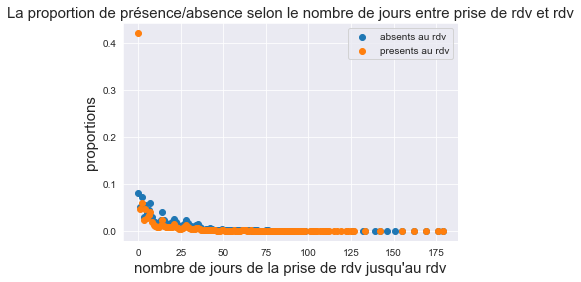

In [128]:
jours_counts, absent_jours, present_jours = proportion_calc(['absent','jours_au_rdv'])

absent_jours_x=absent_jours.index.to_numpy()
absent_jours_y=absent_jours.to_numpy()

present_jours_x=present_jours.index.to_numpy()
present_jours_y=present_jours.to_numpy()

plt.scatter(absent_jours_x , absent_jours_y, label='absents au rdv')
plt.scatter(present_jours_x , present_jours_y, label='presents au rdv')

plt.title("La proportion de présence/absence selon le nombre de jours entre prise de rdv et rdv",fontsize=15)
plt.xlabel("nombre de jours de la prise de rdv jusqu'au rdv",fontsize=15)
plt.ylabel("proportions",fontsize=15)
plt.legend();

    - les proportions des patients absents et des patients présents sont constantes au delà d'environs 30 jours.
    - Avant 30 jours, on remarque une corrélation négative potentielle. Celle-ci est à explorer plus en la mettant en valeu en éliminant les outliers.

    - le graphe n'étant pas particulierement illuminant, je voudrais le ressayer en supprimant les outliers (les rendez-vous pris à plus d'un mois d'écart).

In [129]:
df_jours=df.drop(df.query('jours_au_rdv > 30').index)

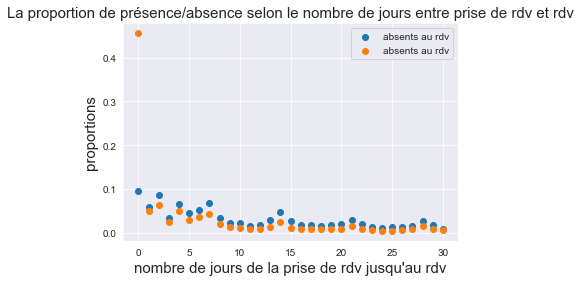

In [130]:
totals_new = df_jours.groupby('absent').count()['id_patient']

jours_counts_new, absent_jours_new, present_jours_new = proportion_calc(['absent','jours_au_rdv'],dataframe=df_jours, total_counts=totals_new)

absent_new_x=absent_jours_new.index.to_numpy()
absent_new_y=absent_jours_new.to_numpy()

present_new_x=present_jours_new.index.to_numpy()
present_new_y=present_jours_new.to_numpy()

plt.scatter(absent_new_x , absent_new_y, label='absents au rdv')
plt.scatter(present_new_x , present_new_y, label='absents au rdv')

plt.title("La proportion de présence/absence selon le nombre de jours entre prise de rdv et rdv",fontsize=15)
plt.xlabel("nombre de jours de la prise de rdv jusqu'au rdv",fontsize=15)
plt.ylabel("proportions",fontsize=15)
plt.legend();

    - les deux échantillons révoluent de façons très similaires, et aucune corrélation particulière n'est à noter.

### Est-ce que certaines maladies caractéristiques sont plus communes chez les patients absents ?

    - je voudrais comparer le nombre d'absents et de présents selon leur état de santé, pour cela je dois d'abord calculer deux dataframes (une pour les patients sans aucune maladie chronique signalée, et une autre pour les patients avec au moins une maladie chronique), à l'aide de quoi je calculerai les proportions approprier.

In [131]:
df_sains = df.query('hypertendu=="non" and diabetique =="non" and alcoolique=="non" and handicape=="non"')
df_malades = df.query('hypertendu=="oui" or diabetique =="oui" or alcoolique=="oui" or handicape=="oui"')

In [132]:
sains_counts, absent_sain_proportion, present_sain_proportion = proportion_calc('absent', dataframe=df_sains)

hypertendu_counts, absent_hypertendu, present_hypertendu = proportion_calc('absent',dataframe=df_malades.query('hypertendu=="oui"'))
print("proportions d'hypertendus :",absent_hypertendu , present_hypertendu)


diabetique_counts, absent_diabetique, present_diabetique = proportion_calc('absent',dataframe=df_malades.query('diabetique=="oui"'))
print("proportions de diabetiques :",absent_diabetique , present_diabetique)


alcoolique_counts, absent_alcoolique, present_alcoolique = proportion_calc('absent',dataframe=df_malades.query('alcoolique=="oui"'))
print("proportions d'alcooliques:",absent_alcoolique , present_alcoolique)


handicape_counts, absent_handicape, present_handicape = proportion_calc('absent',dataframe=df_malades.query('handicape=="oui"'))
print("proportionsd'handicapés :",absent_handicape , present_handicape)

proportions d'hypertendus : 0.16865043032411647 0.20429676310512748
proportions de diabetiques : 0.06441127998535066 0.07367516470925237
proportions d'alcooliques: 0.030305804797656107 0.030570037238613578
proportionsd'handicapés : 0.01785387291704816 0.0206932111142939


In [133]:
absent_proportions =pd.Series([absent_sain_proportion,absent_hypertendu,absent_diabetique,absent_alcoolique, absent_handicape])
present_proportions =pd.Series([present_sain_proportion,present_hypertendu,present_diabetique,present_alcoolique, present_handicape])

    - je visualise les proportions selon des barres pour comparer visuellement.

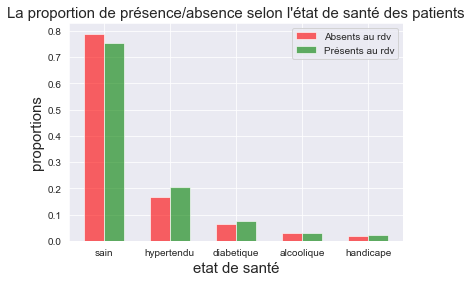

In [134]:
plot_bar(absent_proportions, #proportion1
         present_proportions, #proportion2
         ['sain','hypertendu','diabetique','alcoolique','handicape'], #tick_labels
         "La proportion de présence/absence selon l'état de santé des patients", #title
         "etat de santé", #x_label
         "proportions") #y_label


    - les patients sans conditions chroniques représentent la majorité des patients enregistrés. On y observe plus d'absences que de présences.
    - On remarque plus de présences parmi les patients ayant une condition chronique, notamment les hypertendu en premier lieu et les diabetiques en second lieu.

    - là, je reviens à la question initiale, et je visualise les pourventages de patients selon chaque maladies parmi les absents puis les présents pour voir s'il y a une condition particulière qui est mise en évidence.

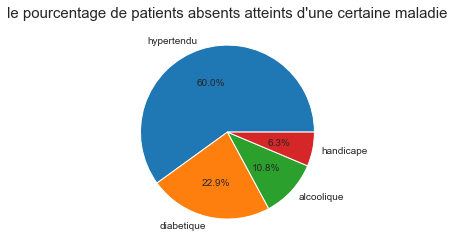

In [135]:
maladies_labels =['hypertendu','diabetique','alcoolique','handicape']

sizes_maladies_absent = absent_proportions[1:5].values

fig2, ax = plt.subplots()
ax.pie(sizes_maladies_absent, labels=maladies_labels, autopct='%1.1f%%')

plt.title("le pourcentage de patients absents atteints d'une certaine maladie",fontsize=15) 
plt.show();

    - Les hypertendus représentent la majorités des patients absents enregistrés ayant une condition chronique (60% de l'échantillon). Les handicapés étant une minorités (6.3%).

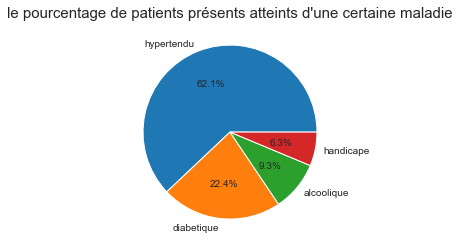

In [136]:
sizes_maladies_present = present_proportions[1:5].values

fig2, ax = plt.subplots()
ax.pie(sizes_maladies_present, labels=maladies_labels, autopct='%1.1f%%')

plt.title("le pourcentage de patients présents atteints d'une certaine maladie",fontsize=15)  
plt.show();

    - Les hypertendus représentent aussi environs 60% des patients présents ayant une condition chronique.

### Est-ce que les absences sont plus fréquentes chez un sexe particulier ?

    - je calcule les proportions appropriées puis visualise le pourcentage des femmes absentes contre les femmes présentes puis de même pour les hommes.

In [137]:
sexe_counts, absent_sexe, present_sexe = proportion_calc(['absent','sexe'])

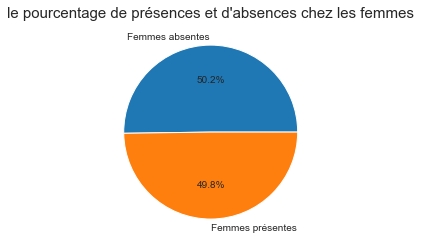

In [142]:
F_labels = 'Femmes absentes', 'Femmes présentes'
sizes_F = [absent_sexe['F'],present_sexe['F']]

fig, ax1 = plt.subplots()
ax1.pie(sizes_F, labels=F_labels, autopct='%1.1f%%')

plt.title("le pourcentage de présences et d'absences chez les femmes",fontsize=15) 
plt.show()

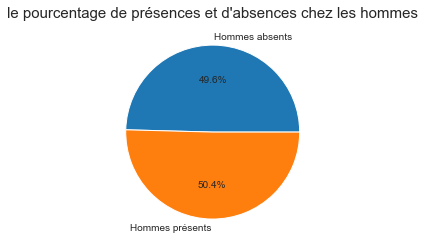

In [143]:
M_labels = 'Hommes absents', 'Hommes présents'
sizes_M = [absent_sexe['M'],present_sexe['M']]
 
fig, ax2 = plt.subplots()
ax2.pie(sizes_M, labels=M_labels, autopct='%1.1f%%')

plt.title("le pourcentage de présences et d'absences chez les hommes",fontsize=15) 
plt.show()

    - On observe qu'il y a autant de présents que d'absents parmi les deux sexes.

### Est-ce que les bénéficiaires du programme Bolsa Familia s'absente plus ou moins que les non-bénéficiaires ?

    - je calcule encore les proportions de chaque cas (bénéficiaire et non-bénéficiaires), parmi les absents puis les présents et je les visualise l'une contre l'autre avec des barres.

In [139]:
secu_social_counts, absent_secu_social, present_secu_social = proportion_calc(['absent','bolsa_familia'])

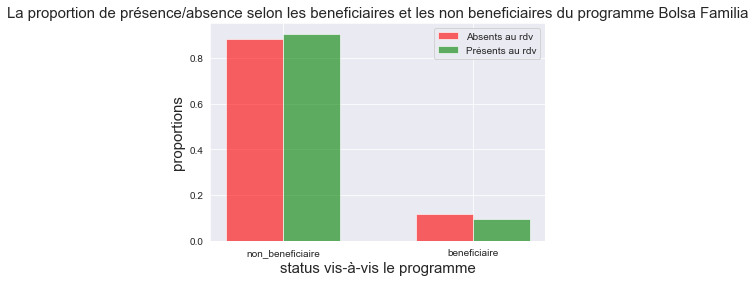

In [140]:
plot_bar(absent_secu_social, #proportion1
         present_secu_social, #proportion2
         ['non_beneficiaire','beneficiaire'], #tick_labels
         "La proportion de présence/absence selon les beneficiaires et les non beneficiaires du programme Bolsa Familia", #title
         "status vis-à-vis le programme", #x_label
         "proportions") #y_label

    - On observe que la majorité des patients ne bénéficient pas du programme de sécurité sociale de Bolsa Familia. Parmi eux, il y a un peu plus de présences qu'il y en a chez les patients bénéficiaires du programme.

<a id='conclusions'></a>
## Conclusions

Cette étude est menée pour chercher et identifier des caractéristiques selon lesquelles on pourrait prédire le mieux le comportement des patients vis-à-vis leurs rendez-vous. Pour cela, plusieurs questions ont été abordé pour décortiquer le probleme. Chacune révèle le suivant :

1. Est-ce que les patients absents pour leur rendez-vous ont reçu un rappel ?

    la constatation inattendues est que parmis les patients qui ont reçu un rappel il y a plus d'absents. Parmi les patients qui n'ont pas reçu d'sms, on trouve encore ceux qui se sont montrés pour leurs rendez-vous.
    Cela va même à l'encontre des fins de cette analyse. Y remédier dépasse le cadre de cette dernière et des études supplémentaires sont necessaires.
    

2. Est-ce que il y a une tranche d'age qui s'est absentée le plus à ses rendez-vous médical ?

    Il y a une faible corrélation entre l'aĝe et les présences aux rendez-vous médical. Les patients agés de plus de 45 ans semblent se montrés plus que leurs homologues moins agés, avec la proportion de présence la plus basse enregistré chez les gens agés de 19-30 ans.
    

3. Est-ce que la durée entre la prise de rendez-vous et le rendez-vous favorise l'absence quand elle est longue ?

    Contrairement aux attentes, aucune corrélation n'est à noter entre le nombre de jours qui sépare la date de prise du rendez-vous et la date de ce dernier.
    

4. Est-ce que certaines maladies caractéristiques sont plus communes chez les patients absents ?

    Encore une fois, la corrélation est très faible. Toutefois, il est à noter que il y a un peu plus d'absences chez les patients déclarés sans maladies chroniques, et plus de présences chez les patients avec au moins une condition médicale.
    Quant aux maladies elles-mêmes, aucune ne semble spécialement commune à une catégorie particulière de patients (absents ou présents).
    

5. Est-ce que les absences sont plus fréquentes chez un sexe particulier ?
    
    Aucune corrélation n'est à noter pour cette question, vu qu'il y a autant de présents que d'absents parmi les femmes et les hommes.
    
    
6. Est-ce que les bénéficiaires du programme Bolsa Familia s'absente plus ou moins que les non-bénéficiaires ?

    Parmi les bénéficiaires du programme de sécurité sociale de Bolsa Familia, les absences sont un peu plus marquées que les présences.
    Parmi les non-bénéficiaires, il y a un peu plus de présence.
    Cela suggère qu'il y a tendance à prendre moins au sérieux les rendez-vous médicaux chez les gens qui bénéficient du programme en question.
    
    

Les corrélations établies , tout autant que l'absence de celles-là, ne permet pas de bien définir les facteurs à la base desquels on pourrait prédire l'absence d'un patient quelconque. Par conséquent, cette analyse établie que les données présentées ne sont pas suffisantes à cette fin.
Loin d'être une analyse concluante, cette étude suggère toutefois de potentiels caractéristiques (parmi lesquels on a observé une légère corrélation en fonction de la présence des patients), en l'occurence : les sms de rappel, l'âge du patient, l'état de santé du patient,  et s'ils font partie d'un programme de sécurité sociale.

### Limitations de l'analyse et études supplémentaires :

Cette analyse est limitée de par le manque de certains détails importants observés dans les données :
   - l'heure du rendez-vous n'est pas enregistrée
   - la date et l'heure de l'sms de rappel ne sont pas enregistrés
   - la cause du rendez-vous, et si c'est lié aux conditions enregistrées
   - s'il s'agit d'une première consultation ou d'un suivi.
Cela n'assurerait pas non plus une correlation instructive sur le comportement des patients vis-à-vis leurs rendez-vous. Pour cela, d'autres études sont envisageables pour mener à bien un tel projet, ci-dessous une suggestion pour ces dernières :
   - une recolte de données et analyse des patients absents, pour comprendre et catégoriser les différentes causes des absences pour identifier un motif récurrent qui s'étend jusqu'à avant le rendez-vous et donnerait une meilleure chance à la prédiction.